# This notebook fine tunes the Inception v3 model to classify normal tissue/LUAD/LUSC

### We first define some basic constants,  the location of the DeepPATH repo, as well as base paths where results and other data are saved.

In [1]:
import os, sys, json, shutil
from os.path import join
import psutil
from utilities import completed_batches

# If we are doing tumor classification: 
# Set classifiation to "Tu"
# ...and training_type to "FT" for finetuning the model 
# If we are doing mutation classification: 
# Set calssification to "Mu"
# ...and training_type to "TS" to train the model from scratch 

# We are doing mutation classification
classification = "TU"
training_type = "FT"


num_cpus = psutil.cpu_count()
num_gpus = !nvidia-smi -L | wc -l
num_gpus = int(num_gpus[0])
batch_size_per_gpu = 30
batch_size = num_gpus * batch_size_per_gpu
print("num_cpus: {}, num_gpus: {}, batch_size: {}".format(num_cpus, num_gpus, batch_size))


deeppath_code = join(os.environ["HOME"],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')

for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
    print("{} created".format(d))
  except:
    print("{} exists".format(d))

num_cpus: 8, num_gpus: 1, batch_size: 30
/mnt/disks/deeppath-data exists
/mnt/disks/deeppath-data/Data exists
/mnt/disks/deeppath-data/Data/Raw exists
/mnt/disks/deeppath-data/inception_checkpoints exists


In [2]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


# Specify tiling parameters
### We place results into a tiling specific directory tree. The first four values below control the tiling. Change these to perform a different tiling. Note that Inception V3 wants 299 pixel tiles; any other size will be scaled by tensor flow before submission to the model. In other words, leave tile_size at 299 and overlap at 0.

In [3]:
tile_size = 299
overlap = 0
background = 25
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
if classification == "TU":
    images_metadata = 'tu_images_metadata.json' # Name of images metadata file  (which will be created below)
else:
    images_metadata = 'mu_images_metadata.json' # Name of images metadata file  (which will be created below)
images_metadata_path = join(tiling, images_metadata) # Path to images metadata file

print("Tiling directory: {}".format(tiling))

for d in (tiling, tiling_logs, tiles):
  try:
    os.makedirs(d)
    print("{} created".format(d))
  except:
    print("{} exists".format(d))

Tiling directory: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles exists


### Specify sorting parameter

In [4]:
if classification == "TU":
    sorting_option = 3
    sorting_params = 'So{}Tu_Sort'.format(sorting_option)
    sorting = join(tiling, sorting_params)
    data_labels_path = join(os.environ["HOME"],'jupyter_DeepPATH','tumor_labels.txt')
else:
    sorting_option = 10
    sorting_params = 'So{}Mu{}_Sort'.format(sorting_option,'NonSilent')
    sorting = join(tiling, sorting_params)
    mutations_metadata = 'mutations_metadata.txt' # Name of mutation metadata file  (which will be created below)
    mutations_metadata_path = join(sorting, mutations_metadata) # Path to metadata file
    data_labels_path = join(sorting, 'hugo_symbols.txt')

sorting_logs = join(sorting, 'logs')
sorted_tiles = join(sorting, 'sorted')

print("Sorting directory: {}".format(sorting))

# Directories where sharded tensor flow formatted records are stored
trainValid_records = join(sorting, 'TFRecord_TrainValid')
test_records = join(sorting, 'TFRecord_Test')
for d in (sorting, sorting_logs, sorted_tiles, trainValid_records, test_records):
  try:
    os.makedirs(d)
    print("{} created".format(d))
  except:
    print("{} exists".format(d))

Sorting directory: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/TFRecord_Test exists


# Specify training, validation, test, and  parameters

In [5]:
# If fine_tune param to TF is True, fine tuning is performed. we do fine tuning for
# tumor classification, but training from scratch for mutation classification
if training_type == "FT":
    fine_tune = True 
    initial_learning_rate = 0.001
    # Use softmax for multiclass classification
    training_mode = '0_softmax' 
    class_number = 3 # Number of tumor classes.
else:
    fine_tune = False 
    initial_learning_rate = 0.1
    # Use sigmoid for multi-class classification
    training_mode = '1_sigmoid'
    class_number = 10 # Number of mutations.

#trainings = join(sorting, "trainings")
training_params = "Cl{}Ft{}_Train".format(str(class_number),str(fine_tune))
training = join(sorting, training_params)
training_logs = join(training, 'logs')

print("Training directory: {}".format(training))

# Directory where pretrained checkpoints are stored
pretrained_checkpoints = join(training, 'pretrained_checkpoints')
# Directory where intermediate training checkpoints are stored
intermediate_checkpoints = join(training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
eval_results = join(training, 'eval_results')
test_results = join(training, 'test_results')
roc_curves = join(training, 'roc_curves')
heatmaps = join(training,'Px'+str(tile_size))

for d in (training, training_logs, intermediate_checkpoints, pretrained_checkpoints,
         eval_results, test_results, roc_curves):
  try:
    os.makedirs(d)
    print("{} created".format(d))
  except:
    print("{} exists".format(d))

Training directory: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/pretrained_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/roc_curves exists


# Get metadata from BQ

### Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and corresponding mutation calls.

### In order to perform a BQ query, we must first establish our credentials
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket" and "credentials" variables below as necessary

In [ ]:
from gcs_access import upload_from_GCS
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC.json' 
upload_from_GCS(bucket, credentials, "/tmp/GAC.json")
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/tmp/GAC.json"

### Now perform a BQ query to get metadata. 

For this purpose, we call query_mutation_metadata(), passing it the SQL query string. query_mutation_metadata() also formats the returned data in the format expected by the tiling and sorting phases.

In [12]:
from get_metadata_from_bq import query_mutation_metadata, query_tumor_metadata

if classification == "TU":
    sql_query = """
        SELECT
          t1.svsFileName,
          t1.file_gdc_id,
          t2.sample_type_name,
          t2.project_short_name,
          t3.clinical_stage
        FROM
          `isb-cgc.metadata.TCGA_slide_images` t1
        INNER JOIN
          `isb-cgc.TCGA_bioclin_v0.Biospecimen` AS t2
        ON
          t1.sample_barcode = t2.sample_barcode
        INNER JOIN
          `isb-cgc.TCGA_bioclin_v0.Clinical` t3
        ON
          t2.case_barcode = t3.case_barcode
        WHERE
          (t2.project_short_name='TCGA-LUAD'
            OR t2.project_short_name='TCGA-LUSC')
          AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'"""
    query_tumor_metadata(images_metadata_path, sql_query)
else:
    sql_query = """
    WITH
      luads AS (
      SELECT
        t1.file_gdc_id AS file_gdc_id,
        t1.svsFilename AS svsFilename,
        t1.sample_barcode AS sample_barcode,
        t2.callerName AS callerName,
        t2.Hugo_Symbol AS Hugo_Symbol,
        t2.Variant_Classification AS Variant_Classification
      FROM
        `isb-cgc.metadata.TCGA_slide_images` t1
      INNER JOIN
        `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation` t2
      ON
        t1.sample_barcode = t2.sample_barcode_tumor
      WHERE
        (t2.project_short_name='TCGA-LUAD')
        AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
      mutations AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        Hugo_Symbol,
        Variant_Classification
      FROM
        luads
      WHERE
        callerName LIKE '%mutect%'
        AND Hugo_Symbol IN ('EGFR',
          'FAT1',
          'FAT4',
          'KEAP1',
          'KRAS',
          'LRP1B',
          'NF1',
          'SETBP1',
          'STK11',
          'TP53')
        AND Variant_Classification IN ('Missense_Mutation',
          'In_Frame_Del',
          'In_Frame_Ins',
          'Frame_Shift',
          'Frame_Shift_Del',
          'Frame_Shift_Ins',
          'Nonsense_Mutation',
          'Nonstop_Mutation' )),
      wts AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        'WT' AS Hugo_Symbol,
        '' AS Variant_Classification
      FROM
        luads
      WHERE
        sample_barcode NOT IN (
        SELECT
          sample_barcode
        FROM
          mutations))
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol,
      Variant_Classification
    FROM
      mutations
    UNION DISTINCT
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol,
      Variant_Classification
    FROM
      wts
    ORDER BY
      sample_barcode,
      Hugo_Symbol  """
    query_mutation_metadata(images_metadata_path, mutations_metadata_path, data_labels_path, sql_query)



# Tile the images listed in the manifest
Images are uploaded, one at a time, from GCS and tiled according to parameters

### Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params,'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

In [ ]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$num_cpus \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


### Optionally save tiling results to GCS

In [ ]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params,'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Sort tiles


### Optionally load previously saved sorting results from GCS

In [12]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, 'data.tar.gz')
loc = join(sorting,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] == gcs:
    !gsutil -m cp $gcs $loc 
    
    !ls -l $loc
    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/data.tar.gz not found


## Perform the sort

In [20]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
os.chdir(os.environ["HOME"])
try:
    shutil.rmtree(sorted_tiles)
except:
    pass
os.mkdir(sorted_tiles)
os.chdir(sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(sorting_logs,root+'.out.log')
err_log_file = join(sorting_logs,root+'.err.log')

!python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=15 --PercentTest=15 \
    --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 --SortingOption=$sorting_option --nSplit=0 \
    > $out_log_file 2> $err_log_file
os.chdir(os.environ["HOME"])


Done removing sorted_tiles
Exception reporting mode: Verbose


# Convert the JPEG tiles into TFRecord format
## First format the training and validation data

In [27]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(trainValid_records)
except:
    pass
os.mkdir(trainValid_records)

%xmode Verbose

if classification == "TU":
    # Format the training data
    print("Starting to format training data")
    func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_image_data.py' )
    root = func.rsplit('/',1)[1].split('.')[0]
    out_log_file = join(sorting_logs,root+'.train.out.log')
    err_log_file = join(sorting_logs,root+'.train.err.log')
    !python $func --directory=$sorted_tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=$num_cpus > $out_log_file 2> $err_log_file

    # Format the validation data
    # NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
    print("Starting to format validation data")
    func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_TF_test.py' )
    root = func.rsplit('/',1)[1].split('.')[0]
    out_log_file = join(sorting_logs,root+'.valid.out.log')
    err_log_file = join(sorting_logs,root+'.valid.err.log')
    !python $func --directory=$sorted_tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename=valid \
        > $out_log_file 2> $err_log_file

else:
    # Format both training and validation data in one step
    print("Starting to format training and validation data")

    func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
    root = func.rsplit('/',1)[1].split('.')[0]
    out_log_file = join(sorting_logs,root+'.train.out.log')
    err_log_file = join(sorting_logs,root+'.train.err.log')
    !python $func --directory=$sorted_tiles/tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=$num_cpus  --labels_names=$data_labels_path --labels=$mutations_metadata_path \
        --PatientID=12 > $out_log_file 2> $err_log_file


Exception reporting mode: Verbose
Starting to format training data
Starting to format validation data
/bin/sh: 1: Syntax error: end of file unexpected


## Now format the test data

In [20]:
# NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(test_records)
except:
    pass
os.mkdir(test_records)

if classification == "TU":
    func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_TF_test.py' )
    root = func.rsplit('/',1)[1].split('.')[0]
    out_log_file = join(sorting_logs,root+'.test.out.log')
    err_log_file = join(sorting_logs,root+'.test.err.log')
    !python $func --directory=$sorted_tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename=test \
        > $out_log_file 2> $err_log_file
else:
    func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
    root = func.rsplit('/',1)[1].split('.')[0]
    out_log_file = join(sorting_logs,root+'.test.out.log')
    err_log_file = join(sorting_logs,root+'.test.err.log')
    !python $func --directory=$sorted_tiles/tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename='test' \
        --labels_names=$data_labels_path --labels=$mutations_metadata_path \
        --PatientID=12 > $out_log_file 2> $err_log_file


## Optionally save sorting results to GCS

In [ ]:
import tarfile

# Populate the tar file
loc = join(sorting,'data.tar')
with tarfile.open(loc, "w") as tar:
    #for name in [sorting_logs, sorted_tiles, trainValid_records, test_records]:
    for name in [trainValid_records, test_records]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Training

## Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, training_params, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


## If training from scratch, first have to install the Bazel build tool, and build the inception model

In [7]:
if training_type == "TS":
    !sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
    !wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
    !chmod +x bazel-0.24.0-installer-linux-x86_64.sh
    !./bazel-0.24.0-installer-linux-x86_64.sh --user
    os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
    !rm bazel-0.24.0-installer-linux-x86_64.sh

    #os.chdir(join(os.environ["HOME"],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
    cwd = os.getcwd()
    os.chdir(join(deeppath_code,'01_training/xClasses'))
    print(os.getcwd())
    !bazel build inception/imagenet_train


 ## Train the model

In [6]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = func.rsplit('/',1)[1]

# Note that the --train_dir directory appears to be deleted and recreated
if training_type == "TS":
    # Note that the --train_dir directory appears to be deleted and recreated
    print("Performing training from scratch")
    !python $func \
        --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
        --fine_tune=$fine_tune --ClassNumber=$class_number --mode=$training_mode
else:
    print("Performing fine tuning")
    !python $func \
        --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
        --pretrained_model_checkpoint_path=$inception_checkpoints/inception-v3/model.ckpt-157585 \
        --fine_tune=$fine_tune --initial_learning_rate=$initial_learning_rate  --ClassNumber=$class_number --mode=$training_mode

2019-06-13 22:05:47.885599: step 4450, loss = 1.57 (25.0 examples/sec; 1.200 sec/batch)
2019-06-13 22:06:00.022545: step 4460, loss = 1.62 (24.6 examples/sec; 1.218 sec/batch)
2019-06-13 22:06:12.250794: step 4470, loss = 1.43 (24.4 examples/sec; 1.228 sec/batch)
2019-06-13 22:06:24.369800: step 4480, loss = 1.33 (24.8 examples/sec; 1.210 sec/batch)
2019-06-13 22:06:36.518571: step 4490, loss = 1.44 (24.9 examples/sec; 1.205 sec/batch)
2019-06-13 22:06:48.561858: step 4500, loss = 1.61 (24.5 examples/sec; 1.222 sec/batch)
2019-06-13 22:07:05.173601: step 4510, loss = 1.51 (24.6 examples/sec; 1.220 sec/batch)
2019-06-13 22:07:17.360991: step 4520, loss = 1.45 (24.9 examples/sec; 1.203 sec/batch)
2019-06-13 22:07:29.391949: step 4530, loss = 1.73 (24.7 examples/sec; 1.216 sec/batch)
2019-06-13 22:07:41.441672: step 4540, loss = 1.34 (24.9 examples/sec; 1.204 sec/batch)
2019-06-13 22:07:53.639594: step 4550, loss = 1.35 (24.8 examples/sec; 1.208 sec/batch)
2019-06-13 22:08:05.848563: step

## Continue training
After halting initial training, you can resume by executiong the following cell.
Note that when you continue training, --fine_tune should be False. If True, the final layer of weights will be randomly set.

In [13]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )

# The first line in the checkpoint file contains the path to the latest checkpoint file set.
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
# Maintain a total count of training batches 
completed = completed_batches(intermediate_checkpoints, pretrained_checkpoints)
print('Completed {} batches'.format(completed))

# The --train_dir directory is immediately deleted, so save intermediate checkpoints by moving into 
# pretrained_checkpoints and renaming according to current batches
os.rename(intermediate_checkpoints, join(pretrained_checkpoints,'_' + completed))

# Change checkpoint_path to point to pretrained_checkpoints
checkpoint_path = checkpoint_path.replace('intermediate_checkpoints','pretrained_checkpoints'  + '/_' + completed)
os.makedirs(intermediate_checkpoints)      
          
!python $func \
    --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode --pretrained_model_checkpoint_path=$checkpoint_path \
    --fine_tune=False --initial_learning_rate=$initial_learning_rate

Completed 140000 batches
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions 

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-06-16 18:22:04.327737: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally
2019-06-16 18:22:14.469669: step 0, loss = 0.93 (1.2 examples/sec; 24.642 sec/batch)
2019-06-16 18:22:46.097524: step 10, loss = 1.14 (23.4 examples/sec; 1.284 sec/batch)
2019-06-16 18:22:58.253637: step 20, loss = 1.05 (25.0 examples/sec; 1.202 sec/batch)
2019-06-16 18:23:10.764358: step 30, loss = 0.96 (24.9 examples/sec; 1.204 sec/batch)
2019-06-16 18:23:23.084213: step 40, loss = 1.10 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 18:23:35.741447: step 50, loss = 1.17 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 18:23:48.013259: step 60, loss = 1.03 (22.7 examples/sec; 1.322 sec/batch)
2019-06-16 18:24:00.235729: step 70, loss = 1.12 (24.8 examples/sec; 1.211 sec/batch)
2019-06-16 18:24:12.586326: step 80, loss = 1.22 (24.8 examples/sec; 1.210 sec/batch)
2019-06-1

2019-06-16 18:41:28.993341: step 890, loss = 1.06 (22.7 examples/sec; 1.323 sec/batch)
2019-06-16 18:41:41.337842: step 900, loss = 0.94 (24.8 examples/sec; 1.209 sec/batch)
2019-06-16 18:41:57.934767: step 910, loss = 1.31 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 18:42:10.228006: step 920, loss = 1.33 (24.9 examples/sec; 1.207 sec/batch)
2019-06-16 18:42:22.533147: step 930, loss = 1.33 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 18:42:34.732100: step 940, loss = 0.97 (24.4 examples/sec; 1.227 sec/batch)
2019-06-16 18:42:46.891707: step 950, loss = 1.06 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 18:42:59.345787: step 960, loss = 1.14 (24.4 examples/sec; 1.229 sec/batch)
2019-06-16 18:43:11.731936: step 970, loss = 0.92 (24.8 examples/sec; 1.208 sec/batch)
2019-06-16 18:43:24.094725: step 980, loss = 0.97 (23.9 examples/sec; 1.255 sec/batch)
2019-06-16 18:43:36.460391: step 990, loss = 1.10 (24.6 examples/sec; 1.218 sec/batch)
2019-06-16 18:43:49.042520: step 1000, loss

2019-06-16 19:01:31.293646: step 1830, loss = 1.02 (24.8 examples/sec; 1.209 sec/batch)
2019-06-16 19:01:43.816342: step 1840, loss = 1.25 (24.7 examples/sec; 1.212 sec/batch)
2019-06-16 19:01:56.180982: step 1850, loss = 1.03 (24.4 examples/sec; 1.228 sec/batch)
2019-06-16 19:02:08.408319: step 1860, loss = 0.98 (24.7 examples/sec; 1.213 sec/batch)
2019-06-16 19:02:20.697828: step 1870, loss = 0.90 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 19:02:33.091678: step 1880, loss = 1.13 (24.8 examples/sec; 1.211 sec/batch)
2019-06-16 19:02:45.302708: step 1890, loss = 1.21 (24.8 examples/sec; 1.212 sec/batch)
2019-06-16 19:02:57.595991: step 1900, loss = 1.20 (24.5 examples/sec; 1.222 sec/batch)
2019-06-16 19:03:14.563000: step 1910, loss = 0.97 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 19:03:26.977671: step 1920, loss = 1.18 (24.7 examples/sec; 1.212 sec/batch)
2019-06-16 19:03:39.353039: step 1930, loss = 1.06 (24.3 examples/sec; 1.233 sec/batch)
2019-06-16 19:03:51.779020: step

2019-06-16 19:21:31.847804: step 2770, loss = 1.04 (24.7 examples/sec; 1.217 sec/batch)
2019-06-16 19:21:44.108377: step 2780, loss = 1.05 (24.2 examples/sec; 1.239 sec/batch)
2019-06-16 19:21:56.669037: step 2790, loss = 1.26 (24.8 examples/sec; 1.208 sec/batch)
2019-06-16 19:22:08.885840: step 2800, loss = 0.95 (24.7 examples/sec; 1.215 sec/batch)
2019-06-16 19:22:25.427028: step 2810, loss = 0.99 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 19:22:37.563166: step 2820, loss = 1.05 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 19:22:49.807276: step 2830, loss = 1.17 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 19:23:02.400018: step 2840, loss = 1.21 (22.9 examples/sec; 1.307 sec/batch)
2019-06-16 19:23:14.675124: step 2850, loss = 1.18 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 19:23:26.987410: step 2860, loss = 0.91 (24.5 examples/sec; 1.222 sec/batch)
2019-06-16 19:23:39.188126: step 2870, loss = 0.86 (24.8 examples/sec; 1.212 sec/batch)
2019-06-16 19:23:51.423710: step

2019-06-16 19:41:36.449864: step 3710, loss = 1.03 (22.8 examples/sec; 1.317 sec/batch)
2019-06-16 19:41:48.971816: step 3720, loss = 1.26 (22.8 examples/sec; 1.316 sec/batch)
2019-06-16 19:42:01.258853: step 3730, loss = 1.28 (25.0 examples/sec; 1.199 sec/batch)
2019-06-16 19:42:13.749732: step 3740, loss = 1.02 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 19:42:26.254633: step 3750, loss = 1.04 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 19:42:38.533180: step 3760, loss = 1.10 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 19:42:50.743993: step 3770, loss = 1.39 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 19:43:02.997605: step 3780, loss = 0.90 (24.6 examples/sec; 1.217 sec/batch)
2019-06-16 19:43:15.142576: step 3790, loss = 1.10 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 19:43:27.406513: step 3800, loss = 1.01 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 19:43:44.195563: step 3810, loss = 0.99 (24.8 examples/sec; 1.209 sec/batch)
2019-06-16 19:43:56.446089: step

2019-06-16 20:01:34.380407: step 4650, loss = 0.98 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 20:01:46.674430: step 4660, loss = 1.09 (25.0 examples/sec; 1.201 sec/batch)
2019-06-16 20:01:59.015004: step 4670, loss = 1.08 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 20:02:11.453860: step 4680, loss = 1.15 (24.9 examples/sec; 1.207 sec/batch)
2019-06-16 20:02:23.692323: step 4690, loss = 1.14 (24.7 examples/sec; 1.214 sec/batch)
2019-06-16 20:02:36.157981: step 4700, loss = 1.02 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 20:02:53.340391: step 4710, loss = 1.06 (22.7 examples/sec; 1.322 sec/batch)
2019-06-16 20:03:05.608589: step 4720, loss = 1.14 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 20:03:17.945295: step 4730, loss = 1.02 (24.9 examples/sec; 1.206 sec/batch)
2019-06-16 20:03:30.360924: step 4740, loss = 1.14 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 20:03:42.575878: step 4750, loss = 1.18 (23.0 examples/sec; 1.307 sec/batch)
2019-06-16 20:03:54.936719: step

2019-06-16 20:21:38.776794: step 5590, loss = 1.17 (24.6 examples/sec; 1.217 sec/batch)
2019-06-16 20:21:51.174640: step 5600, loss = 1.10 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 20:22:07.762526: step 5610, loss = 1.55 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 20:22:20.155512: step 5620, loss = 1.07 (24.5 examples/sec; 1.223 sec/batch)
2019-06-16 20:22:32.359762: step 5630, loss = 1.23 (24.8 examples/sec; 1.208 sec/batch)
2019-06-16 20:22:44.916100: step 5640, loss = 1.17 (22.9 examples/sec; 1.311 sec/batch)
2019-06-16 20:22:57.456937: step 5650, loss = 1.03 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 20:23:09.732851: step 5660, loss = 1.07 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 20:23:22.184041: step 5670, loss = 1.01 (23.0 examples/sec; 1.305 sec/batch)
2019-06-16 20:23:34.379830: step 5680, loss = 1.22 (24.6 examples/sec; 1.218 sec/batch)
2019-06-16 20:23:46.898154: step 5690, loss = 1.21 (22.8 examples/sec; 1.315 sec/batch)
2019-06-16 20:23:59.321659: step

2019-06-16 20:41:43.290643: step 6530, loss = 1.25 (24.5 examples/sec; 1.222 sec/batch)
2019-06-16 20:41:55.498680: step 6540, loss = 0.92 (22.9 examples/sec; 1.311 sec/batch)
2019-06-16 20:42:07.606828: step 6550, loss = 1.04 (25.0 examples/sec; 1.202 sec/batch)
2019-06-16 20:42:19.765657: step 6560, loss = 1.13 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 20:42:32.147490: step 6570, loss = 0.89 (22.7 examples/sec; 1.320 sec/batch)
2019-06-16 20:42:44.474803: step 6580, loss = 1.14 (24.4 examples/sec; 1.230 sec/batch)
2019-06-16 20:42:56.647436: step 6590, loss = 1.24 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 20:43:09.243742: step 6600, loss = 1.01 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 20:43:25.903964: step 6610, loss = 1.13 (24.7 examples/sec; 1.215 sec/batch)
2019-06-16 20:43:38.052123: step 6620, loss = 1.12 (24.7 examples/sec; 1.214 sec/batch)
2019-06-16 20:43:50.512975: step 6630, loss = 1.17 (25.0 examples/sec; 1.201 sec/batch)
2019-06-16 20:44:02.784715: step

2019-06-16 21:01:42.665923: step 7470, loss = 0.96 (24.8 examples/sec; 1.211 sec/batch)
2019-06-16 21:01:54.917137: step 7480, loss = 1.10 (25.0 examples/sec; 1.200 sec/batch)
2019-06-16 21:02:07.340500: step 7490, loss = 1.03 (22.8 examples/sec; 1.317 sec/batch)
2019-06-16 21:02:19.505803: step 7500, loss = 1.04 (24.7 examples/sec; 1.214 sec/batch)
2019-06-16 21:02:36.364426: step 7510, loss = 1.16 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 21:02:48.789111: step 7520, loss = 1.15 (24.5 examples/sec; 1.224 sec/batch)
2019-06-16 21:03:01.063973: step 7530, loss = 0.96 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 21:03:13.364207: step 7540, loss = 1.02 (24.5 examples/sec; 1.223 sec/batch)
2019-06-16 21:03:25.621469: step 7550, loss = 1.16 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 21:03:37.821181: step 7560, loss = 1.12 (25.1 examples/sec; 1.197 sec/batch)
2019-06-16 21:03:49.969400: step 7570, loss = 1.27 (24.7 examples/sec; 1.212 sec/batch)
2019-06-16 21:04:02.347880: step

2019-06-16 21:21:44.557347: step 8410, loss = 1.28 (24.6 examples/sec; 1.218 sec/batch)
2019-06-16 21:21:56.819200: step 8420, loss = 1.11 (24.8 examples/sec; 1.212 sec/batch)
2019-06-16 21:22:09.140157: step 8430, loss = 0.98 (22.9 examples/sec; 1.310 sec/batch)
2019-06-16 21:22:21.328657: step 8440, loss = 1.05 (24.8 examples/sec; 1.211 sec/batch)
2019-06-16 21:22:33.502678: step 8450, loss = 1.23 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 21:22:45.835713: step 8460, loss = 1.06 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 21:22:58.167801: step 8470, loss = 1.06 (23.0 examples/sec; 1.306 sec/batch)
2019-06-16 21:23:10.424500: step 8480, loss = 0.92 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 21:23:22.776284: step 8490, loss = 1.09 (23.2 examples/sec; 1.295 sec/batch)
2019-06-16 21:23:34.927100: step 8500, loss = 1.02 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 21:23:51.877339: step 8510, loss = 1.01 (24.6 examples/sec; 1.219 sec/batch)
2019-06-16 21:24:04.437100: step

2019-06-16 21:41:40.895367: step 9350, loss = 0.99 (24.5 examples/sec; 1.223 sec/batch)
2019-06-16 21:41:53.086835: step 9360, loss = 0.96 (24.2 examples/sec; 1.239 sec/batch)
2019-06-16 21:42:05.640946: step 9370, loss = 0.93 (24.9 examples/sec; 1.207 sec/batch)
2019-06-16 21:42:17.808968: step 9380, loss = 1.12 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 21:42:30.196763: step 9390, loss = 0.93 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 21:42:42.694076: step 9400, loss = 1.11 (24.8 examples/sec; 1.212 sec/batch)
2019-06-16 21:42:59.404819: step 9410, loss = 1.06 (24.5 examples/sec; 1.223 sec/batch)
2019-06-16 21:43:11.697765: step 9420, loss = 1.27 (24.7 examples/sec; 1.217 sec/batch)
2019-06-16 21:43:24.338803: step 9430, loss = 0.93 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 21:43:36.552600: step 9440, loss = 0.98 (24.7 examples/sec; 1.216 sec/batch)
2019-06-16 21:43:49.135072: step 9450, loss = 1.16 (25.1 examples/sec; 1.197 sec/batch)
2019-06-16 21:44:01.503698: step

2019-06-16 22:01:31.872446: step 10280, loss = 1.12 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 22:01:44.377049: step 10290, loss = 1.05 (23.2 examples/sec; 1.295 sec/batch)
2019-06-16 22:01:56.821279: step 10300, loss = 0.94 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 22:02:13.661070: step 10310, loss = 1.14 (23.9 examples/sec; 1.257 sec/batch)
2019-06-16 22:02:25.915172: step 10320, loss = 1.05 (24.6 examples/sec; 1.217 sec/batch)
2019-06-16 22:02:38.217700: step 10330, loss = 1.28 (24.9 examples/sec; 1.203 sec/batch)
2019-06-16 22:02:50.362799: step 10340, loss = 0.97 (24.7 examples/sec; 1.215 sec/batch)
2019-06-16 22:03:02.791255: step 10350, loss = 1.25 (24.9 examples/sec; 1.207 sec/batch)
2019-06-16 22:03:15.028933: step 10360, loss = 1.02 (22.7 examples/sec; 1.321 sec/batch)
2019-06-16 22:03:27.225452: step 10370, loss = 1.03 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 22:03:39.566520: step 10380, loss = 1.13 (23.1 examples/sec; 1.301 sec/batch)
2019-06-16 22:03:51.9

2019-06-16 22:21:21.600670: step 11210, loss = 0.92 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 22:21:34.000388: step 11220, loss = 0.91 (24.6 examples/sec; 1.222 sec/batch)
2019-06-16 22:21:46.126760: step 11230, loss = 1.02 (25.0 examples/sec; 1.198 sec/batch)
2019-06-16 22:21:58.236094: step 11240, loss = 1.27 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 22:22:10.639373: step 11250, loss = 1.12 (24.8 examples/sec; 1.207 sec/batch)
2019-06-16 22:22:23.017288: step 11260, loss = 0.98 (23.1 examples/sec; 1.299 sec/batch)
2019-06-16 22:22:35.479313: step 11270, loss = 1.07 (25.0 examples/sec; 1.202 sec/batch)
2019-06-16 22:22:47.798380: step 11280, loss = 0.93 (24.3 examples/sec; 1.232 sec/batch)
2019-06-16 22:23:00.313949: step 11290, loss = 0.97 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 22:23:12.569206: step 11300, loss = 0.96 (23.0 examples/sec; 1.304 sec/batch)
2019-06-16 22:23:29.478705: step 11310, loss = 1.05 (24.6 examples/sec; 1.221 sec/batch)
2019-06-16 22:23:41.7

2019-06-16 22:41:09.913287: step 12140, loss = 0.91 (22.7 examples/sec; 1.324 sec/batch)
2019-06-16 22:41:22.258404: step 12150, loss = 1.00 (23.3 examples/sec; 1.288 sec/batch)
2019-06-16 22:41:34.490310: step 12160, loss = 1.15 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 22:41:47.015471: step 12170, loss = 1.01 (24.7 examples/sec; 1.213 sec/batch)
2019-06-16 22:41:59.359580: step 12180, loss = 1.25 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 22:42:11.761931: step 12190, loss = 1.09 (24.6 examples/sec; 1.220 sec/batch)
2019-06-16 22:42:24.431431: step 12200, loss = 1.07 (24.4 examples/sec; 1.228 sec/batch)
2019-06-16 22:42:41.502173: step 12210, loss = 0.97 (24.8 examples/sec; 1.208 sec/batch)
2019-06-16 22:42:53.662664: step 12220, loss = 1.04 (24.5 examples/sec; 1.225 sec/batch)
2019-06-16 22:43:06.131857: step 12230, loss = 1.32 (25.0 examples/sec; 1.198 sec/batch)
2019-06-16 22:43:18.243393: step 12240, loss = 1.11 (24.9 examples/sec; 1.206 sec/batch)
2019-06-16 22:43:30.4

2019-06-16 23:00:56.858533: step 13070, loss = 1.03 (25.0 examples/sec; 1.201 sec/batch)
2019-06-16 23:01:09.040341: step 13080, loss = 1.48 (24.7 examples/sec; 1.212 sec/batch)
2019-06-16 23:01:21.351993: step 13090, loss = 0.97 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 23:01:33.757381: step 13100, loss = 1.29 (24.6 examples/sec; 1.222 sec/batch)
2019-06-16 23:01:50.561372: step 13110, loss = 0.84 (23.0 examples/sec; 1.305 sec/batch)
2019-06-16 23:02:02.752029: step 13120, loss = 0.97 (25.0 examples/sec; 1.198 sec/batch)
2019-06-16 23:02:15.080505: step 13130, loss = 0.99 (24.5 examples/sec; 1.224 sec/batch)
2019-06-16 23:02:27.477918: step 13140, loss = 0.99 (24.5 examples/sec; 1.224 sec/batch)
2019-06-16 23:02:39.653983: step 13150, loss = 1.23 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 23:02:52.000507: step 13160, loss = 0.97 (22.9 examples/sec; 1.311 sec/batch)
2019-06-16 23:03:04.317496: step 13170, loss = 0.85 (24.8 examples/sec; 1.212 sec/batch)
2019-06-16 23:03:16.6

2019-06-16 23:20:41.871410: step 14000, loss = 1.11 (24.8 examples/sec; 1.209 sec/batch)
2019-06-16 23:20:58.279999: step 14010, loss = 1.02 (25.0 examples/sec; 1.199 sec/batch)
2019-06-16 23:21:10.737400: step 14020, loss = 0.99 (22.5 examples/sec; 1.331 sec/batch)
2019-06-16 23:21:23.252391: step 14030, loss = 0.93 (24.1 examples/sec; 1.244 sec/batch)
2019-06-16 23:21:35.645547: step 14040, loss = 1.00 (22.9 examples/sec; 1.307 sec/batch)
2019-06-16 23:21:47.985470: step 14050, loss = 0.98 (22.8 examples/sec; 1.315 sec/batch)
2019-06-16 23:22:00.414843: step 14060, loss = 1.00 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 23:22:12.749485: step 14070, loss = 1.00 (24.8 examples/sec; 1.210 sec/batch)
2019-06-16 23:22:24.986703: step 14080, loss = 1.28 (24.8 examples/sec; 1.211 sec/batch)
2019-06-16 23:22:37.184349: step 14090, loss = 1.01 (24.9 examples/sec; 1.207 sec/batch)
2019-06-16 23:22:49.466262: step 14100, loss = 0.88 (24.3 examples/sec; 1.234 sec/batch)
2019-06-16 23:23:05.9

2019-06-16 23:40:31.971571: step 14930, loss = 1.16 (24.7 examples/sec; 1.215 sec/batch)
2019-06-16 23:40:44.376151: step 14940, loss = 0.98 (22.8 examples/sec; 1.314 sec/batch)
2019-06-16 23:40:56.981743: step 14950, loss = 1.15 (24.2 examples/sec; 1.239 sec/batch)
2019-06-16 23:41:09.227121: step 14960, loss = 1.09 (25.0 examples/sec; 1.199 sec/batch)
2019-06-16 23:41:21.651475: step 14970, loss = 0.96 (24.9 examples/sec; 1.206 sec/batch)
2019-06-16 23:41:34.024810: step 14980, loss = 1.24 (24.2 examples/sec; 1.242 sec/batch)
2019-06-16 23:41:46.231998: step 14990, loss = 1.17 (24.3 examples/sec; 1.235 sec/batch)
2019-06-16 23:41:58.550535: step 15000, loss = 1.11 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 23:42:18.360453: step 15010, loss = 0.96 (24.9 examples/sec; 1.205 sec/batch)
2019-06-16 23:42:30.922281: step 15020, loss = 1.03 (22.9 examples/sec; 1.312 sec/batch)
2019-06-16 23:42:43.325844: step 15030, loss = 1.13 (25.0 examples/sec; 1.201 sec/batch)
2019-06-16 23:42:55.7

2019-06-17 00:00:17.759062: step 15860, loss = 1.08 (24.5 examples/sec; 1.225 sec/batch)
2019-06-17 00:00:30.121643: step 15870, loss = 1.15 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 00:00:42.368254: step 15880, loss = 0.93 (22.9 examples/sec; 1.308 sec/batch)
2019-06-17 00:00:54.706663: step 15890, loss = 1.04 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 00:01:07.027341: step 15900, loss = 1.12 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 00:01:24.119837: step 15910, loss = 1.11 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 00:01:36.362019: step 15920, loss = 1.14 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 00:01:48.935264: step 15930, loss = 1.13 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 00:02:01.126367: step 15940, loss = 1.03 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 00:02:13.438462: step 15950, loss = 1.10 (24.1 examples/sec; 1.244 sec/batch)
2019-06-17 00:02:25.882811: step 15960, loss = 1.35 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 00:02:38.1

2019-06-17 00:20:01.383618: step 16790, loss = 1.21 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 00:20:13.507044: step 16800, loss = 1.08 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 00:20:30.058586: step 16810, loss = 1.29 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 00:20:42.343732: step 16820, loss = 1.30 (24.3 examples/sec; 1.234 sec/batch)
2019-06-17 00:20:54.734693: step 16830, loss = 1.00 (23.0 examples/sec; 1.306 sec/batch)
2019-06-17 00:21:07.054016: step 16840, loss = 1.24 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 00:21:19.406046: step 16850, loss = 0.96 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 00:21:31.839527: step 16860, loss = 0.94 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 00:21:44.328327: step 16870, loss = 1.11 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 00:21:56.672207: step 16880, loss = 0.96 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 00:22:09.023488: step 16890, loss = 1.09 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 00:22:21.3

2019-06-17 00:39:53.119154: step 17720, loss = 1.07 (24.5 examples/sec; 1.225 sec/batch)
2019-06-17 00:40:05.572948: step 17730, loss = 1.12 (24.3 examples/sec; 1.234 sec/batch)
2019-06-17 00:40:17.842363: step 17740, loss = 1.03 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 00:40:30.009888: step 17750, loss = 1.12 (25.0 examples/sec; 1.202 sec/batch)
2019-06-17 00:40:42.103260: step 17760, loss = 0.99 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 00:40:54.474514: step 17770, loss = 1.13 (24.0 examples/sec; 1.249 sec/batch)
2019-06-17 00:41:06.680301: step 17780, loss = 0.95 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 00:41:19.020087: step 17790, loss = 1.16 (24.3 examples/sec; 1.234 sec/batch)
2019-06-17 00:41:31.364573: step 17800, loss = 1.29 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 00:41:47.971013: step 17810, loss = 0.88 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 00:42:00.299193: step 17820, loss = 1.13 (22.7 examples/sec; 1.321 sec/batch)
2019-06-17 00:42:12.6

2019-06-17 00:59:38.324943: step 18650, loss = 1.04 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 00:59:50.750876: step 18660, loss = 1.02 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 01:00:03.293972: step 18670, loss = 1.05 (23.0 examples/sec; 1.302 sec/batch)
2019-06-17 01:00:15.840217: step 18680, loss = 1.10 (23.8 examples/sec; 1.260 sec/batch)
2019-06-17 01:00:28.265064: step 18690, loss = 0.97 (24.2 examples/sec; 1.241 sec/batch)
2019-06-17 01:00:40.398160: step 18700, loss = 0.99 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 01:00:57.288597: step 18710, loss = 0.91 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 01:01:09.905562: step 18720, loss = 1.12 (23.3 examples/sec; 1.287 sec/batch)
2019-06-17 01:01:22.364127: step 18730, loss = 1.15 (24.3 examples/sec; 1.232 sec/batch)
2019-06-17 01:01:34.753409: step 18740, loss = 1.21 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 01:01:46.910981: step 18750, loss = 1.17 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 01:01:59.1

2019-06-17 01:19:26.463897: step 19580, loss = 1.01 (22.5 examples/sec; 1.330 sec/batch)
2019-06-17 01:19:38.747851: step 19590, loss = 0.98 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 01:19:51.173461: step 19600, loss = 1.08 (22.8 examples/sec; 1.314 sec/batch)
2019-06-17 01:20:08.039965: step 19610, loss = 0.92 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 01:20:20.361719: step 19620, loss = 1.04 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 01:20:32.536269: step 19630, loss = 1.02 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 01:20:44.940141: step 19640, loss = 0.87 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 01:20:57.428783: step 19650, loss = 1.09 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 01:21:09.576574: step 19660, loss = 1.20 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 01:21:21.800020: step 19670, loss = 1.09 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 01:21:34.208021: step 19680, loss = 0.91 (22.9 examples/sec; 1.308 sec/batch)
2019-06-17 01:21:46.4

2019-06-17 01:39:22.900388: step 20510, loss = 1.05 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 01:39:35.361495: step 20520, loss = 1.09 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 01:39:47.875645: step 20530, loss = 0.95 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 01:40:00.164114: step 20540, loss = 1.04 (24.3 examples/sec; 1.234 sec/batch)
2019-06-17 01:40:12.415022: step 20550, loss = 1.03 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 01:40:24.649895: step 20560, loss = 1.11 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 01:40:37.193619: step 20570, loss = 1.12 (23.4 examples/sec; 1.283 sec/batch)
2019-06-17 01:40:49.527629: step 20580, loss = 1.09 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 01:41:01.783435: step 20590, loss = 1.12 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 01:41:14.246805: step 20600, loss = 1.29 (22.9 examples/sec; 1.308 sec/batch)
2019-06-17 01:41:30.849382: step 20610, loss = 0.95 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 01:41:43.3

2019-06-17 01:59:10.399925: step 21440, loss = 1.11 (24.3 examples/sec; 1.232 sec/batch)
2019-06-17 01:59:22.777478: step 21450, loss = 1.01 (23.8 examples/sec; 1.258 sec/batch)
2019-06-17 01:59:35.240343: step 21460, loss = 1.13 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 01:59:47.663099: step 21470, loss = 1.04 (22.4 examples/sec; 1.339 sec/batch)
2019-06-17 02:00:00.011030: step 21480, loss = 0.92 (22.6 examples/sec; 1.329 sec/batch)
2019-06-17 02:00:12.312093: step 21490, loss = 1.05 (24.4 examples/sec; 1.228 sec/batch)
2019-06-17 02:00:24.634959: step 21500, loss = 1.07 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 02:00:41.818270: step 21510, loss = 1.10 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 02:00:54.276677: step 21520, loss = 1.17 (24.0 examples/sec; 1.251 sec/batch)
2019-06-17 02:01:06.648206: step 21530, loss = 1.07 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 02:01:19.078433: step 21540, loss = 1.11 (22.8 examples/sec; 1.314 sec/batch)
2019-06-17 02:01:31.3

2019-06-17 02:19:02.417698: step 22370, loss = 1.11 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 02:19:14.734283: step 22380, loss = 1.24 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 02:19:26.991870: step 22390, loss = 0.97 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 02:19:39.478433: step 22400, loss = 1.22 (22.6 examples/sec; 1.327 sec/batch)
2019-06-17 02:19:56.545615: step 22410, loss = 1.22 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 02:20:08.782728: step 22420, loss = 1.12 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 02:20:21.152531: step 22430, loss = 1.06 (23.8 examples/sec; 1.259 sec/batch)
2019-06-17 02:20:33.619493: step 22440, loss = 1.07 (22.6 examples/sec; 1.325 sec/batch)
2019-06-17 02:20:45.889942: step 22450, loss = 1.05 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 02:20:58.214615: step 22460, loss = 1.15 (22.9 examples/sec; 1.310 sec/batch)
2019-06-17 02:21:10.478618: step 22470, loss = 1.22 (24.5 examples/sec; 1.226 sec/batch)
2019-06-17 02:21:22.7

2019-06-17 02:38:53.043765: step 23300, loss = 1.12 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 02:39:09.839673: step 23310, loss = 0.96 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 02:39:22.033311: step 23320, loss = 1.01 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 02:39:34.279276: step 23330, loss = 0.92 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 02:39:46.529513: step 23340, loss = 0.97 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 02:39:59.078630: step 23350, loss = 0.86 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 02:40:11.493663: step 23360, loss = 1.21 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 02:40:23.783077: step 23370, loss = 0.96 (22.6 examples/sec; 1.327 sec/batch)
2019-06-17 02:40:35.982028: step 23380, loss = 0.94 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 02:40:48.293100: step 23390, loss = 1.23 (24.3 examples/sec; 1.237 sec/batch)
2019-06-17 02:41:00.580416: step 23400, loss = 1.14 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 02:41:17.7

2019-06-17 02:58:44.402962: step 24230, loss = 1.22 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 02:58:56.841757: step 24240, loss = 1.03 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 02:59:09.138288: step 24250, loss = 1.12 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 02:59:21.528572: step 24260, loss = 1.06 (23.6 examples/sec; 1.271 sec/batch)
2019-06-17 02:59:33.851288: step 24270, loss = 0.91 (23.0 examples/sec; 1.302 sec/batch)
2019-06-17 02:59:46.102647: step 24280, loss = 1.02 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 02:59:58.684111: step 24290, loss = 1.00 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 03:00:11.091478: step 24300, loss = 1.10 (22.7 examples/sec; 1.322 sec/batch)
2019-06-17 03:00:27.887414: step 24310, loss = 0.95 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 03:00:40.054356: step 24320, loss = 0.95 (24.5 examples/sec; 1.225 sec/batch)
2019-06-17 03:00:52.313928: step 24330, loss = 1.13 (24.5 examples/sec; 1.226 sec/batch)
2019-06-17 03:01:04.5

2019-06-17 03:18:33.809887: step 25160, loss = 1.25 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 03:18:46.057203: step 25170, loss = 0.89 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 03:18:58.473972: step 25180, loss = 0.97 (24.3 examples/sec; 1.232 sec/batch)
2019-06-17 03:19:10.645257: step 25190, loss = 1.26 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 03:19:22.993111: step 25200, loss = 1.25 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 03:19:39.782268: step 25210, loss = 1.30 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 03:19:52.156845: step 25220, loss = 0.94 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 03:20:04.361090: step 25230, loss = 1.07 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 03:20:16.726031: step 25240, loss = 1.20 (22.7 examples/sec; 1.321 sec/batch)
2019-06-17 03:20:29.083015: step 25250, loss = 1.11 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 03:20:41.454017: step 25260, loss = 1.04 (22.7 examples/sec; 1.322 sec/batch)
2019-06-17 03:20:54.0

2019-06-17 03:38:20.981179: step 26090, loss = 1.00 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 03:38:33.235912: step 26100, loss = 1.03 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 03:38:50.013249: step 26110, loss = 1.01 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 03:39:02.250952: step 26120, loss = 0.94 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 03:39:14.581086: step 26130, loss = 1.11 (22.9 examples/sec; 1.310 sec/batch)
2019-06-17 03:39:27.023483: step 26140, loss = 1.29 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 03:39:39.388575: step 26150, loss = 1.08 (24.4 examples/sec; 1.231 sec/batch)
2019-06-17 03:39:51.901239: step 26160, loss = 0.91 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 03:40:04.286581: step 26170, loss = 1.02 (24.8 examples/sec; 1.207 sec/batch)
2019-06-17 03:40:16.483065: step 26180, loss = 1.09 (23.7 examples/sec; 1.265 sec/batch)
2019-06-17 03:40:28.948807: step 26190, loss = 1.06 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 03:40:41.3

2019-06-17 03:58:16.951026: step 27020, loss = 0.88 (24.4 examples/sec; 1.228 sec/batch)
2019-06-17 03:58:29.118689: step 27030, loss = 1.03 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 03:58:41.465874: step 27040, loss = 0.86 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 03:58:53.738664: step 27050, loss = 1.14 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 03:59:06.742034: step 27060, loss = 1.06 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 03:59:19.020500: step 27070, loss = 1.09 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 03:59:31.437483: step 27080, loss = 1.07 (23.6 examples/sec; 1.274 sec/batch)
2019-06-17 03:59:43.782317: step 27090, loss = 1.22 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 03:59:56.244430: step 27100, loss = 1.13 (23.0 examples/sec; 1.306 sec/batch)
2019-06-17 04:00:12.771475: step 27110, loss = 1.11 (24.4 examples/sec; 1.228 sec/batch)
2019-06-17 04:00:25.163712: step 27120, loss = 1.18 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 04:00:37.4

2019-06-17 04:18:06.765027: step 27950, loss = 1.03 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 04:18:18.927549: step 27960, loss = 0.92 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 04:18:31.274010: step 27970, loss = 1.14 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 04:18:43.495455: step 27980, loss = 0.99 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 04:18:55.860147: step 27990, loss = 1.07 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 04:19:08.236680: step 28000, loss = 1.04 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 04:19:25.256751: step 28010, loss = 1.02 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 04:19:37.637489: step 28020, loss = 1.09 (24.2 examples/sec; 1.239 sec/batch)
2019-06-17 04:19:50.063258: step 28030, loss = 1.07 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 04:20:02.527880: step 28040, loss = 1.00 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 04:20:14.916229: step 28050, loss = 0.93 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 04:20:27.1

2019-06-17 04:37:55.522229: step 28880, loss = 1.28 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 04:38:07.897354: step 28890, loss = 1.03 (22.8 examples/sec; 1.315 sec/batch)
2019-06-17 04:38:20.497037: step 28900, loss = 1.12 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 04:38:37.482413: step 28910, loss = 1.14 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 04:38:49.777899: step 28920, loss = 0.98 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 04:39:02.036368: step 28930, loss = 1.25 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 04:39:14.188655: step 28940, loss = 0.94 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 04:39:26.520657: step 28950, loss = 1.18 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 04:39:38.878824: step 28960, loss = 1.24 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 04:39:51.137478: step 28970, loss = 1.23 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 04:40:03.403334: step 28980, loss = 1.11 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 04:40:15.8

2019-06-17 04:57:49.711113: step 29810, loss = 1.26 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 04:58:01.915663: step 29820, loss = 1.16 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 04:58:14.199978: step 29830, loss = 1.22 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 04:58:26.469686: step 29840, loss = 1.01 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 04:58:38.685914: step 29850, loss = 1.02 (24.5 examples/sec; 1.225 sec/batch)
2019-06-17 04:58:51.100738: step 29860, loss = 1.06 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 04:59:03.550135: step 29870, loss = 1.05 (23.1 examples/sec; 1.298 sec/batch)
2019-06-17 04:59:15.765690: step 29880, loss = 0.88 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 04:59:27.971364: step 29890, loss = 1.13 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 04:59:40.295613: step 29900, loss = 1.01 (24.2 examples/sec; 1.237 sec/batch)
2019-06-17 04:59:57.208206: step 29910, loss = 0.91 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 05:00:09.4

2019-06-17 05:17:42.620060: step 30740, loss = 1.09 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 05:17:54.771656: step 30750, loss = 1.07 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 05:18:07.279011: step 30760, loss = 0.97 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 05:18:19.813416: step 30770, loss = 1.15 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 05:18:32.336233: step 30780, loss = 1.11 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 05:18:44.722374: step 30790, loss = 1.19 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 05:18:57.021186: step 30800, loss = 0.99 (22.8 examples/sec; 1.318 sec/batch)
2019-06-17 05:19:13.787890: step 30810, loss = 1.04 (24.4 examples/sec; 1.231 sec/batch)
2019-06-17 05:19:26.129626: step 30820, loss = 0.95 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 05:19:38.572024: step 30830, loss = 0.92 (25.0 examples/sec; 1.202 sec/batch)
2019-06-17 05:19:51.079083: step 30840, loss = 1.04 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 05:20:03.3

2019-06-17 05:37:32.790247: step 31670, loss = 1.11 (24.1 examples/sec; 1.244 sec/batch)
2019-06-17 05:37:45.069907: step 31680, loss = 1.09 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 05:37:57.399469: step 31690, loss = 0.95 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 05:38:09.877595: step 31700, loss = 1.10 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 05:38:26.809911: step 31710, loss = 1.14 (22.6 examples/sec; 1.329 sec/batch)
2019-06-17 05:38:39.007363: step 31720, loss = 1.07 (23.7 examples/sec; 1.264 sec/batch)
2019-06-17 05:38:51.488555: step 31730, loss = 1.01 (22.6 examples/sec; 1.325 sec/batch)
2019-06-17 05:39:03.980731: step 31740, loss = 1.13 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 05:39:16.351770: step 31750, loss = 0.98 (22.6 examples/sec; 1.330 sec/batch)
2019-06-17 05:39:28.525586: step 31760, loss = 1.00 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 05:39:40.817951: step 31770, loss = 1.20 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 05:39:52.9

2019-06-17 05:57:21.184114: step 32600, loss = 1.14 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 05:57:37.998717: step 32610, loss = 1.09 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 05:57:50.415608: step 32620, loss = 1.24 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 05:58:02.725025: step 32630, loss = 1.00 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 05:58:15.154192: step 32640, loss = 1.13 (24.2 examples/sec; 1.239 sec/batch)
2019-06-17 05:58:27.492972: step 32650, loss = 1.02 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 05:58:39.743092: step 32660, loss = 0.86 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 05:58:52.105744: step 32670, loss = 1.05 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 05:59:04.424152: step 32680, loss = 1.09 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 05:59:16.842162: step 32690, loss = 0.85 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 05:59:29.368607: step 32700, loss = 0.90 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 05:59:46.2

2019-06-17 06:17:13.722863: step 33530, loss = 1.09 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 06:17:26.079588: step 33540, loss = 1.19 (22.9 examples/sec; 1.312 sec/batch)
2019-06-17 06:17:38.490439: step 33550, loss = 0.97 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 06:17:50.938089: step 33560, loss = 1.14 (24.0 examples/sec; 1.251 sec/batch)
2019-06-17 06:18:03.199291: step 33570, loss = 1.04 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 06:18:15.745337: step 33580, loss = 0.98 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 06:18:28.066057: step 33590, loss = 1.21 (24.5 examples/sec; 1.225 sec/batch)
2019-06-17 06:18:40.383776: step 33600, loss = 1.00 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 06:18:57.229041: step 33610, loss = 0.97 (22.7 examples/sec; 1.321 sec/batch)
2019-06-17 06:19:09.675209: step 33620, loss = 1.09 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 06:19:22.114140: step 33630, loss = 1.08 (22.0 examples/sec; 1.362 sec/batch)
2019-06-17 06:19:34.6

2019-06-17 06:37:03.532205: step 34460, loss = 1.15 (23.9 examples/sec; 1.256 sec/batch)
2019-06-17 06:37:15.737371: step 34470, loss = 1.10 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 06:37:28.020469: step 34480, loss = 0.97 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 06:37:40.362266: step 34490, loss = 1.20 (22.8 examples/sec; 1.313 sec/batch)
2019-06-17 06:37:52.633771: step 34500, loss = 1.15 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 06:38:09.809538: step 34510, loss = 1.24 (23.9 examples/sec; 1.254 sec/batch)
2019-06-17 06:38:22.046845: step 34520, loss = 1.03 (23.4 examples/sec; 1.284 sec/batch)
2019-06-17 06:38:34.627102: step 34530, loss = 1.10 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 06:38:46.896883: step 34540, loss = 1.22 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 06:38:59.220776: step 34550, loss = 1.13 (25.0 examples/sec; 1.201 sec/batch)
2019-06-17 06:39:11.439033: step 34560, loss = 1.17 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 06:39:23.7

2019-06-17 06:56:55.783288: step 35390, loss = 1.12 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 06:57:08.233411: step 35400, loss = 1.00 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 06:57:25.136870: step 35410, loss = 1.14 (24.2 examples/sec; 1.237 sec/batch)
2019-06-17 06:57:37.597488: step 35420, loss = 1.13 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 06:57:49.963145: step 35430, loss = 1.07 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 06:58:02.741575: step 35440, loss = 0.89 (22.7 examples/sec; 1.320 sec/batch)
2019-06-17 06:58:15.057924: step 35450, loss = 0.96 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 06:58:27.508273: step 35460, loss = 1.16 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 06:58:39.592292: step 35470, loss = 1.03 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 06:58:51.797848: step 35480, loss = 1.27 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 06:59:04.273861: step 35490, loss = 1.19 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 06:59:16.7

2019-06-17 07:16:51.099525: step 36320, loss = 1.06 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 07:17:03.302028: step 36330, loss = 1.17 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 07:17:15.763453: step 36340, loss = 0.97 (22.6 examples/sec; 1.326 sec/batch)
2019-06-17 07:17:28.144871: step 36350, loss = 0.99 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 07:17:40.556083: step 36360, loss = 1.06 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 07:17:52.862885: step 36370, loss = 0.95 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 07:18:05.117512: step 36380, loss = 1.04 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 07:18:17.412132: step 36390, loss = 1.08 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 07:18:29.687258: step 36400, loss = 1.07 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 07:18:46.430612: step 36410, loss = 1.08 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 07:18:59.020005: step 36420, loss = 0.95 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 07:19:11.2

2019-06-17 07:36:39.982186: step 37250, loss = 1.04 (24.4 examples/sec; 1.228 sec/batch)
2019-06-17 07:36:52.331950: step 37260, loss = 1.08 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 07:37:04.831613: step 37270, loss = 0.97 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 07:37:17.017342: step 37280, loss = 0.90 (24.4 examples/sec; 1.227 sec/batch)
2019-06-17 07:37:29.267746: step 37290, loss = 1.21 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 07:37:41.542071: step 37300, loss = 1.15 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 07:37:58.698184: step 37310, loss = 1.13 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 07:38:11.172088: step 37320, loss = 1.10 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 07:38:23.828794: step 37330, loss = 1.01 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 07:38:36.101849: step 37340, loss = 1.09 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 07:38:48.571785: step 37350, loss = 0.96 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 07:39:00.8

2019-06-17 07:56:29.371221: step 38180, loss = 0.96 (24.5 examples/sec; 1.226 sec/batch)
2019-06-17 07:56:41.525768: step 38190, loss = 1.01 (24.4 examples/sec; 1.232 sec/batch)
2019-06-17 07:56:53.949848: step 38200, loss = 1.15 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 07:57:10.453767: step 38210, loss = 1.06 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 07:57:22.755368: step 38220, loss = 0.92 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 07:57:35.147425: step 38230, loss = 1.09 (22.7 examples/sec; 1.323 sec/batch)
2019-06-17 07:57:47.502706: step 38240, loss = 1.13 (22.5 examples/sec; 1.331 sec/batch)
2019-06-17 07:57:59.833054: step 38250, loss = 1.00 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 07:58:12.133605: step 38260, loss = 0.98 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 07:58:24.531346: step 38270, loss = 0.95 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 07:58:36.784370: step 38280, loss = 1.18 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 07:58:49.1

2019-06-17 08:16:21.544408: step 39110, loss = 1.12 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 08:16:33.781840: step 39120, loss = 1.07 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 08:16:46.310525: step 39130, loss = 1.26 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 08:16:58.545736: step 39140, loss = 1.07 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 08:17:10.690537: step 39150, loss = 1.08 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 08:17:22.964506: step 39160, loss = 1.23 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 08:17:35.329116: step 39170, loss = 1.24 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 08:17:47.782752: step 39180, loss = 1.04 (22.8 examples/sec; 1.316 sec/batch)
2019-06-17 08:18:00.101971: step 39190, loss = 1.22 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 08:18:12.620503: step 39200, loss = 0.95 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 08:18:29.412294: step 39210, loss = 1.13 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 08:18:41.5

2019-06-17 08:36:12.976738: step 40040, loss = 1.25 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 08:36:25.288038: step 40050, loss = 1.33 (22.6 examples/sec; 1.325 sec/batch)
2019-06-17 08:36:37.413649: step 40060, loss = 1.16 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 08:36:49.639682: step 40070, loss = 1.26 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 08:37:02.063880: step 40080, loss = 0.87 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 08:37:14.321955: step 40090, loss = 0.90 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 08:37:26.845575: step 40100, loss = 1.10 (22.8 examples/sec; 1.313 sec/batch)
2019-06-17 08:37:43.960944: step 40110, loss = 1.07 (24.4 examples/sec; 1.227 sec/batch)
2019-06-17 08:37:56.567071: step 40120, loss = 0.85 (24.1 examples/sec; 1.245 sec/batch)
2019-06-17 08:38:08.820639: step 40130, loss = 0.90 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 08:38:21.056516: step 40140, loss = 1.00 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 08:38:33.4

2019-06-17 08:56:01.957344: step 40970, loss = 1.01 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 08:56:14.178499: step 40980, loss = 1.14 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 08:56:26.580879: step 40990, loss = 1.26 (24.1 examples/sec; 1.246 sec/batch)
2019-06-17 08:56:38.822756: step 41000, loss = 0.96 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 08:56:55.850873: step 41010, loss = 1.21 (22.8 examples/sec; 1.314 sec/batch)
2019-06-17 08:57:08.043592: step 41020, loss = 1.06 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 08:57:20.394888: step 41030, loss = 1.14 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 08:57:32.987257: step 41040, loss = 1.08 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 08:57:45.550704: step 41050, loss = 1.01 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 08:57:57.748249: step 41060, loss = 0.96 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 08:58:10.139920: step 41070, loss = 1.05 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 08:58:22.5

2019-06-17 09:15:54.196299: step 41900, loss = 1.04 (22.7 examples/sec; 1.320 sec/batch)
2019-06-17 09:16:11.367961: step 41910, loss = 1.01 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 09:16:23.883917: step 41920, loss = 0.93 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 09:16:36.249169: step 41930, loss = 1.06 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 09:16:48.583766: step 41940, loss = 0.92 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 09:17:00.966529: step 41950, loss = 1.01 (24.4 examples/sec; 1.231 sec/batch)
2019-06-17 09:17:13.411935: step 41960, loss = 1.09 (24.2 examples/sec; 1.241 sec/batch)
2019-06-17 09:17:25.783937: step 41970, loss = 1.17 (22.6 examples/sec; 1.326 sec/batch)
2019-06-17 09:17:38.241209: step 41980, loss = 1.01 (23.3 examples/sec; 1.286 sec/batch)
2019-06-17 09:17:50.349924: step 41990, loss = 0.99 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 09:18:02.754567: step 42000, loss = 1.11 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 09:18:19.8

2019-06-17 09:35:47.483972: step 42830, loss = 1.38 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 09:35:59.590747: step 42840, loss = 0.91 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 09:36:12.245173: step 42850, loss = 1.02 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 09:36:24.502445: step 42860, loss = 0.98 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 09:36:36.659107: step 42870, loss = 0.93 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 09:36:48.884828: step 42880, loss = 1.09 (23.9 examples/sec; 1.253 sec/batch)
2019-06-17 09:37:01.468770: step 42890, loss = 0.85 (22.9 examples/sec; 1.308 sec/batch)
2019-06-17 09:37:13.833848: step 42900, loss = 0.97 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 09:37:30.627639: step 42910, loss = 1.15 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 09:37:42.804361: step 42920, loss = 1.37 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 09:37:55.276457: step 42930, loss = 1.01 (24.5 examples/sec; 1.226 sec/batch)
2019-06-17 09:38:07.4

2019-06-17 09:55:37.497418: step 43760, loss = 1.03 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 09:55:49.681814: step 43770, loss = 0.93 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 09:56:01.975120: step 43780, loss = 1.20 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 09:56:14.154106: step 43790, loss = 1.00 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 09:56:26.492688: step 43800, loss = 1.17 (23.1 examples/sec; 1.301 sec/batch)
2019-06-17 09:56:43.571032: step 43810, loss = 1.03 (24.2 examples/sec; 1.237 sec/batch)
2019-06-17 09:56:56.058237: step 43820, loss = 0.98 (23.0 examples/sec; 1.302 sec/batch)
2019-06-17 09:57:08.270232: step 43830, loss = 0.93 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 09:57:20.700357: step 43840, loss = 1.12 (22.8 examples/sec; 1.318 sec/batch)
2019-06-17 09:57:32.924620: step 43850, loss = 1.03 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 09:57:45.257589: step 43860, loss = 1.03 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 09:57:57.4

2019-06-17 10:15:26.284459: step 44690, loss = 0.95 (24.4 examples/sec; 1.232 sec/batch)
2019-06-17 10:15:38.660141: step 44700, loss = 1.09 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 10:15:55.455624: step 44710, loss = 0.95 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 10:16:07.973968: step 44720, loss = 1.06 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 10:16:20.196389: step 44730, loss = 1.05 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 10:16:32.820920: step 44740, loss = 0.97 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 10:16:45.214764: step 44750, loss = 1.08 (24.2 examples/sec; 1.241 sec/batch)
2019-06-17 10:16:57.621163: step 44760, loss = 0.98 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 10:17:10.077385: step 44770, loss = 1.13 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 10:17:22.551292: step 44780, loss = 1.23 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 10:17:34.828037: step 44790, loss = 1.19 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 10:17:47.3

2019-06-17 10:35:23.917457: step 45620, loss = 0.97 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 10:35:36.406057: step 45630, loss = 1.08 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 10:35:48.666110: step 45640, loss = 0.92 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 10:36:01.280024: step 45650, loss = 1.13 (22.7 examples/sec; 1.321 sec/batch)
2019-06-17 10:36:13.594729: step 45660, loss = 0.94 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 10:36:25.803732: step 45670, loss = 0.91 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 10:36:37.996414: step 45680, loss = 0.99 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 10:36:50.177066: step 45690, loss = 1.14 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 10:37:02.624435: step 45700, loss = 1.09 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 10:37:19.409565: step 45710, loss = 1.13 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 10:37:31.617474: step 45720, loss = 1.11 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 10:37:43.7

2019-06-17 10:55:10.685190: step 46550, loss = 1.11 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 10:55:22.882097: step 46560, loss = 0.95 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 10:55:35.137791: step 46570, loss = 0.95 (24.4 examples/sec; 1.227 sec/batch)
2019-06-17 10:55:47.457744: step 46580, loss = 1.14 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 10:55:59.892791: step 46590, loss = 1.09 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 10:56:12.149231: step 46600, loss = 0.84 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 10:56:29.031217: step 46610, loss = 1.00 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 10:56:41.343730: step 46620, loss = 0.95 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 10:56:53.569347: step 46630, loss = 1.04 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 10:57:05.945976: step 46640, loss = 1.05 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 10:57:18.314716: step 46650, loss = 1.14 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 10:57:30.7

2019-06-17 11:15:00.149372: step 47480, loss = 0.92 (25.0 examples/sec; 1.201 sec/batch)
2019-06-17 11:15:12.515548: step 47490, loss = 0.93 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 11:15:24.661624: step 47500, loss = 0.92 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 11:15:41.422563: step 47510, loss = 1.13 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 11:15:53.613673: step 47520, loss = 1.26 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 11:16:05.980860: step 47530, loss = 1.17 (22.6 examples/sec; 1.326 sec/batch)
2019-06-17 11:16:18.334243: step 47540, loss = 1.02 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 11:16:30.674777: step 47550, loss = 1.18 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 11:16:43.066666: step 47560, loss = 1.13 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 11:16:55.631776: step 47570, loss = 1.01 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 11:17:08.143238: step 47580, loss = 1.14 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 11:17:20.4

2019-06-17 11:34:51.991726: step 48410, loss = 1.01 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 11:35:04.371436: step 48420, loss = 1.18 (24.4 examples/sec; 1.232 sec/batch)
2019-06-17 11:35:16.627610: step 48430, loss = 1.04 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 11:35:29.320290: step 48440, loss = 1.04 (23.1 examples/sec; 1.300 sec/batch)
2019-06-17 11:35:41.499644: step 48450, loss = 0.91 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 11:35:53.778198: step 48460, loss = 1.09 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 11:36:06.027915: step 48470, loss = 1.12 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 11:36:18.275049: step 48480, loss = 1.09 (23.5 examples/sec; 1.278 sec/batch)
2019-06-17 11:36:30.813547: step 48490, loss = 1.15 (22.8 examples/sec; 1.315 sec/batch)
2019-06-17 11:36:43.140329: step 48500, loss = 1.06 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 11:37:00.460728: step 48510, loss = 1.02 (22.4 examples/sec; 1.337 sec/batch)
2019-06-17 11:37:12.7

2019-06-17 11:54:40.867577: step 49340, loss = 0.88 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 11:54:53.317957: step 49350, loss = 1.14 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 11:55:05.631977: step 49360, loss = 1.20 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 11:55:18.159260: step 49370, loss = 0.96 (25.1 examples/sec; 1.196 sec/batch)
2019-06-17 11:55:30.309192: step 49380, loss = 1.05 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 11:55:42.756334: step 49390, loss = 0.88 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 11:55:54.926927: step 49400, loss = 0.90 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 11:56:11.463677: step 49410, loss = 1.14 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 11:56:23.873059: step 49420, loss = 1.02 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 11:56:36.368932: step 49430, loss = 0.92 (23.9 examples/sec; 1.254 sec/batch)
2019-06-17 11:56:48.950808: step 49440, loss = 1.11 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 11:57:01.2

2019-06-17 12:14:31.748862: step 50270, loss = 0.94 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 12:14:43.902988: step 50280, loss = 1.03 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 12:14:56.280568: step 50290, loss = 1.14 (22.8 examples/sec; 1.313 sec/batch)
2019-06-17 12:15:08.610133: step 50300, loss = 0.91 (22.9 examples/sec; 1.312 sec/batch)
2019-06-17 12:15:25.433215: step 50310, loss = 1.11 (22.8 examples/sec; 1.313 sec/batch)
2019-06-17 12:15:37.623357: step 50320, loss = 1.10 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 12:15:49.820807: step 50330, loss = 1.08 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 12:16:02.109546: step 50340, loss = 1.05 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 12:16:14.362619: step 50350, loss = 1.08 (24.3 examples/sec; 1.235 sec/batch)
2019-06-17 12:16:26.949520: step 50360, loss = 0.95 (22.8 examples/sec; 1.318 sec/batch)
2019-06-17 12:16:39.430312: step 50370, loss = 1.03 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 12:16:51.7

2019-06-17 12:34:22.823294: step 51200, loss = 1.03 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 12:34:39.966188: step 51210, loss = 1.07 (24.4 examples/sec; 1.231 sec/batch)
2019-06-17 12:34:52.559376: step 51220, loss = 0.90 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 12:35:04.822035: step 51230, loss = 0.95 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 12:35:17.354528: step 51240, loss = 1.22 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 12:35:29.775185: step 51250, loss = 1.04 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 12:35:42.074573: step 51260, loss = 1.05 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 12:35:54.306319: step 51270, loss = 0.87 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 12:36:06.829178: step 51280, loss = 1.31 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 12:36:19.139915: step 51290, loss = 0.99 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 12:36:31.353815: step 51300, loss = 0.95 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 12:36:48.1

2019-06-17 12:54:17.593292: step 52130, loss = 0.86 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 12:54:29.851261: step 52140, loss = 0.96 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 12:54:42.249572: step 52150, loss = 1.12 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 12:54:54.734372: step 52160, loss = 0.99 (22.6 examples/sec; 1.330 sec/batch)
2019-06-17 12:55:06.991108: step 52170, loss = 0.93 (24.4 examples/sec; 1.227 sec/batch)
2019-06-17 12:55:19.495258: step 52180, loss = 1.05 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 12:55:31.618731: step 52190, loss = 1.09 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 12:55:43.812161: step 52200, loss = 1.19 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 12:56:00.591286: step 52210, loss = 1.21 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 12:56:13.172080: step 52220, loss = 1.05 (22.6 examples/sec; 1.325 sec/batch)
2019-06-17 12:56:25.569921: step 52230, loss = 0.94 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 12:56:37.8

2019-06-17 13:14:08.249435: step 53060, loss = 1.09 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 13:14:20.441606: step 53070, loss = 1.00 (25.2 examples/sec; 1.193 sec/batch)
2019-06-17 13:14:32.879147: step 53080, loss = 1.04 (24.0 examples/sec; 1.251 sec/batch)
2019-06-17 13:14:45.139011: step 53090, loss = 0.92 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 13:14:57.396873: step 53100, loss = 1.00 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 13:15:14.980911: step 53110, loss = 1.21 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 13:15:27.246385: step 53120, loss = 0.94 (24.3 examples/sec; 1.236 sec/batch)
2019-06-17 13:15:39.605203: step 53130, loss = 0.89 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 13:15:51.874489: step 53140, loss = 0.97 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 13:16:04.050550: step 53150, loss = 0.98 (25.1 examples/sec; 1.196 sec/batch)
2019-06-17 13:16:16.380674: step 53160, loss = 1.05 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 13:16:28.7

2019-06-17 13:33:57.888206: step 53990, loss = 1.32 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 13:34:10.238458: step 54000, loss = 0.96 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 13:34:27.513189: step 54010, loss = 1.10 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 13:34:39.917101: step 54020, loss = 1.03 (24.2 examples/sec; 1.242 sec/batch)
2019-06-17 13:34:52.577111: step 54030, loss = 0.99 (24.6 examples/sec; 1.219 sec/batch)
2019-06-17 13:35:04.878352: step 54040, loss = 1.12 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 13:35:17.042403: step 54050, loss = 1.03 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 13:35:29.610492: step 54060, loss = 1.06 (23.0 examples/sec; 1.306 sec/batch)
2019-06-17 13:35:42.091721: step 54070, loss = 1.12 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 13:35:54.251853: step 54080, loss = 0.94 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 13:36:06.883018: step 54090, loss = 1.12 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 13:36:19.2

2019-06-17 13:53:53.031641: step 54920, loss = 0.87 (24.2 examples/sec; 1.242 sec/batch)
2019-06-17 13:54:05.478406: step 54930, loss = 0.91 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 13:54:17.906459: step 54940, loss = 0.79 (24.3 examples/sec; 1.236 sec/batch)
2019-06-17 13:54:30.280238: step 54950, loss = 0.97 (22.7 examples/sec; 1.320 sec/batch)
2019-06-17 13:54:42.727556: step 54960, loss = 1.03 (25.0 examples/sec; 1.202 sec/batch)
2019-06-17 13:54:55.155648: step 54970, loss = 1.10 (22.8 examples/sec; 1.315 sec/batch)
2019-06-17 13:55:07.680446: step 54980, loss = 1.12 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 13:55:20.135460: step 54990, loss = 1.00 (22.5 examples/sec; 1.335 sec/batch)
2019-06-17 13:55:32.429883: step 55000, loss = 1.14 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 13:55:52.665968: step 55010, loss = 0.93 (23.2 examples/sec; 1.294 sec/batch)
2019-06-17 13:56:04.897508: step 55020, loss = 0.85 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 13:56:17.2

2019-06-17 14:13:50.458710: step 55850, loss = 1.01 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 14:14:02.727950: step 55860, loss = 1.07 (24.8 examples/sec; 1.211 sec/batch)
2019-06-17 14:14:15.126015: step 55870, loss = 1.02 (24.2 examples/sec; 1.238 sec/batch)
2019-06-17 14:14:27.391897: step 55880, loss = 1.09 (24.1 examples/sec; 1.244 sec/batch)
2019-06-17 14:14:40.113001: step 55890, loss = 1.01 (22.9 examples/sec; 1.310 sec/batch)
2019-06-17 14:14:52.543103: step 55900, loss = 1.03 (24.8 examples/sec; 1.207 sec/batch)
2019-06-17 14:15:09.725123: step 55910, loss = 1.23 (24.3 examples/sec; 1.233 sec/batch)
2019-06-17 14:15:21.992093: step 55920, loss = 1.06 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 14:15:34.188497: step 55930, loss = 1.14 (25.0 examples/sec; 1.201 sec/batch)
2019-06-17 14:15:46.470188: step 55940, loss = 1.08 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 14:15:58.714628: step 55950, loss = 0.90 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 14:16:11.1

2019-06-17 14:33:37.800376: step 56780, loss = 1.01 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 14:33:50.199022: step 56790, loss = 0.92 (24.2 examples/sec; 1.239 sec/batch)
2019-06-17 14:34:02.649448: step 56800, loss = 1.17 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 14:34:19.794997: step 56810, loss = 1.11 (22.7 examples/sec; 1.324 sec/batch)
2019-06-17 14:34:32.044939: step 56820, loss = 1.19 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 14:34:44.480338: step 56830, loss = 1.22 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 14:34:56.783999: step 56840, loss = 0.87 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 14:35:08.883005: step 56850, loss = 0.94 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 14:35:21.310735: step 56860, loss = 1.08 (24.4 examples/sec; 1.229 sec/batch)
2019-06-17 14:35:33.637253: step 56870, loss = 1.19 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 14:35:45.766166: step 56880, loss = 0.97 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 14:35:58.4

2019-06-17 14:53:30.238946: step 57710, loss = 1.20 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 14:53:42.312128: step 57720, loss = 1.05 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 14:53:54.885309: step 57730, loss = 1.00 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 14:54:07.193816: step 57740, loss = 0.97 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 14:54:19.473252: step 57750, loss = 1.18 (22.7 examples/sec; 1.320 sec/batch)
2019-06-17 14:54:31.743397: step 57760, loss = 1.03 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 14:54:44.056618: step 57770, loss = 1.26 (24.8 examples/sec; 1.212 sec/batch)
2019-06-17 14:54:56.554329: step 57780, loss = 1.07 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 14:55:08.957049: step 57790, loss = 1.15 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 14:55:21.201194: step 57800, loss = 1.02 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 14:55:38.239597: step 57810, loss = 1.04 (22.7 examples/sec; 1.321 sec/batch)
2019-06-17 14:55:50.3

2019-06-17 15:13:20.107975: step 58640, loss = 1.00 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 15:13:32.665708: step 58650, loss = 1.19 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 15:13:45.193727: step 58660, loss = 1.13 (24.2 examples/sec; 1.238 sec/batch)
2019-06-17 15:13:57.357276: step 58670, loss = 1.18 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 15:14:09.611961: step 58680, loss = 1.06 (24.2 examples/sec; 1.239 sec/batch)
2019-06-17 15:14:21.759411: step 58690, loss = 1.08 (25.1 examples/sec; 1.196 sec/batch)
2019-06-17 15:14:34.225096: step 58700, loss = 1.01 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 15:14:51.053942: step 58710, loss = 1.14 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 15:15:03.525065: step 58720, loss = 0.96 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 15:15:15.846071: step 58730, loss = 0.95 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 15:15:28.270711: step 58740, loss = 0.99 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 15:15:40.5

2019-06-17 15:33:09.034232: step 59570, loss = 1.36 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 15:33:21.246071: step 59580, loss = 1.10 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 15:33:33.561282: step 59590, loss = 0.97 (25.1 examples/sec; 1.193 sec/batch)
2019-06-17 15:33:45.915611: step 59600, loss = 1.06 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 15:34:02.737651: step 59610, loss = 0.87 (24.7 examples/sec; 1.217 sec/batch)
2019-06-17 15:34:14.979843: step 59620, loss = 1.02 (25.1 examples/sec; 1.195 sec/batch)
2019-06-17 15:34:27.234805: step 59630, loss = 1.19 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 15:34:39.486792: step 59640, loss = 1.01 (24.6 examples/sec; 1.218 sec/batch)
2019-06-17 15:34:51.677620: step 59650, loss = 1.10 (22.9 examples/sec; 1.308 sec/batch)
2019-06-17 15:35:03.992454: step 59660, loss = 1.13 (24.5 examples/sec; 1.227 sec/batch)
2019-06-17 15:35:16.448101: step 59670, loss = 1.07 (23.1 examples/sec; 1.299 sec/batch)
2019-06-17 15:35:28.5

2019-06-17 15:52:59.841924: step 60500, loss = 0.87 (22.7 examples/sec; 1.320 sec/batch)
2019-06-17 15:53:17.005931: step 60510, loss = 0.85 (24.5 examples/sec; 1.226 sec/batch)
2019-06-17 15:53:29.335508: step 60520, loss = 1.13 (22.8 examples/sec; 1.315 sec/batch)
2019-06-17 15:53:41.431129: step 60530, loss = 1.00 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 15:53:53.698745: step 60540, loss = 0.92 (24.7 examples/sec; 1.212 sec/batch)
2019-06-17 15:54:06.091610: step 60550, loss = 1.07 (24.6 examples/sec; 1.222 sec/batch)
2019-06-17 15:54:18.582955: step 60560, loss = 0.92 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 15:54:31.006621: step 60570, loss = 1.07 (22.8 examples/sec; 1.314 sec/batch)
2019-06-17 15:54:43.364059: step 60580, loss = 1.08 (24.9 examples/sec; 1.206 sec/batch)
2019-06-17 15:54:55.806367: step 60590, loss = 0.89 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 15:55:08.155046: step 60600, loss = 1.10 (24.5 examples/sec; 1.222 sec/batch)
2019-06-17 15:55:25.3

2019-06-17 16:12:53.469021: step 61430, loss = 1.06 (24.6 examples/sec; 1.220 sec/batch)
2019-06-17 16:13:05.657387: step 61440, loss = 0.87 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 16:13:17.912621: step 61450, loss = 1.17 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 16:13:30.156340: step 61460, loss = 1.11 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 16:13:42.501687: step 61470, loss = 0.93 (24.2 examples/sec; 1.237 sec/batch)
2019-06-17 16:13:54.670611: step 61480, loss = 0.99 (25.1 examples/sec; 1.195 sec/batch)
2019-06-17 16:14:06.979080: step 61490, loss = 1.04 (25.1 examples/sec; 1.194 sec/batch)
2019-06-17 16:14:19.180979: step 61500, loss = 0.85 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 16:14:36.201061: step 61510, loss = 1.18 (22.8 examples/sec; 1.314 sec/batch)
2019-06-17 16:14:48.291914: step 61520, loss = 1.11 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 16:15:00.376439: step 61530, loss = 1.22 (24.9 examples/sec; 1.207 sec/batch)
2019-06-17 16:15:12.7

2019-06-17 16:32:31.171330: step 62360, loss = 0.98 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 16:32:43.223174: step 62370, loss = 0.97 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 16:32:55.568801: step 62380, loss = 0.94 (24.6 examples/sec; 1.217 sec/batch)
2019-06-17 16:33:07.726940: step 62390, loss = 1.01 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 16:33:19.915003: step 62400, loss = 0.96 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 16:33:36.447769: step 62410, loss = 1.08 (25.0 examples/sec; 1.199 sec/batch)
2019-06-17 16:33:48.651343: step 62420, loss = 0.98 (25.0 examples/sec; 1.201 sec/batch)
2019-06-17 16:34:00.898496: step 62430, loss = 0.98 (24.7 examples/sec; 1.214 sec/batch)
2019-06-17 16:34:13.125621: step 62440, loss = 0.98 (22.8 examples/sec; 1.313 sec/batch)
2019-06-17 16:34:25.300525: step 62450, loss = 1.03 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 16:34:37.896583: step 62460, loss = 1.08 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 16:34:50.4

2019-06-17 16:52:09.885204: step 63290, loss = 1.16 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 16:52:22.363175: step 63300, loss = 1.17 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 16:52:38.976588: step 63310, loss = 1.08 (24.8 examples/sec; 1.208 sec/batch)
2019-06-17 16:52:51.360108: step 63320, loss = 1.08 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 16:53:03.487634: step 63330, loss = 1.02 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 16:53:15.717050: step 63340, loss = 1.12 (25.1 examples/sec; 1.195 sec/batch)
2019-06-17 16:53:27.930394: step 63350, loss = 1.00 (24.9 examples/sec; 1.203 sec/batch)
2019-06-17 16:53:40.272176: step 63360, loss = 0.87 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 16:53:52.416494: step 63370, loss = 1.05 (24.9 examples/sec; 1.205 sec/batch)
2019-06-17 16:54:04.748673: step 63380, loss = 0.92 (24.7 examples/sec; 1.215 sec/batch)
2019-06-17 16:54:17.178704: step 63390, loss = 1.01 (23.0 examples/sec; 1.306 sec/batch)
2019-06-17 16:54:29.6

2019-06-17 17:11:56.912902: step 64220, loss = 1.01 (24.9 examples/sec; 1.204 sec/batch)
2019-06-17 17:12:09.086003: step 64230, loss = 1.20 (25.0 examples/sec; 1.202 sec/batch)
2019-06-17 17:12:21.439110: step 64240, loss = 0.96 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 17:12:33.764826: step 64250, loss = 1.04 (22.8 examples/sec; 1.317 sec/batch)
2019-06-17 17:12:46.150230: step 64260, loss = 1.02 (23.0 examples/sec; 1.304 sec/batch)
2019-06-17 17:12:58.494609: step 64270, loss = 0.88 (22.8 examples/sec; 1.316 sec/batch)
2019-06-17 17:13:10.870697: step 64280, loss = 0.94 (22.8 examples/sec; 1.315 sec/batch)
2019-06-17 17:13:23.141645: step 64290, loss = 1.01 (25.1 examples/sec; 1.194 sec/batch)
2019-06-17 17:13:35.203662: step 64300, loss = 0.98 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 17:13:52.230931: step 64310, loss = 1.05 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 17:14:04.550539: step 64320, loss = 1.12 (25.1 examples/sec; 1.196 sec/batch)
2019-06-17 17:14:16.8

2019-06-17 17:31:40.155234: step 65150, loss = 0.90 (25.0 examples/sec; 1.200 sec/batch)
2019-06-17 17:31:52.517276: step 65160, loss = 1.13 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 17:32:04.900451: step 65170, loss = 1.08 (24.4 examples/sec; 1.230 sec/batch)
2019-06-17 17:32:17.423516: step 65180, loss = 1.13 (22.7 examples/sec; 1.319 sec/batch)
2019-06-17 17:32:29.717520: step 65190, loss = 1.08 (25.0 examples/sec; 1.198 sec/batch)
2019-06-17 17:32:41.865610: step 65200, loss = 1.09 (22.9 examples/sec; 1.309 sec/batch)
2019-06-17 17:32:58.330454: step 65210, loss = 0.92 (24.7 examples/sec; 1.216 sec/batch)
2019-06-17 17:33:10.493731: step 65220, loss = 1.01 (24.6 examples/sec; 1.221 sec/batch)
2019-06-17 17:33:22.774757: step 65230, loss = 1.24 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 17:33:34.835442: step 65240, loss = 0.89 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 17:33:47.114256: step 65250, loss = 0.88 (24.8 examples/sec; 1.209 sec/batch)
2019-06-17 17:33:59.5

2019-06-17 17:51:22.419414: step 66080, loss = 1.05 (24.3 examples/sec; 1.237 sec/batch)
2019-06-17 17:51:34.591992: step 66090, loss = 0.95 (25.1 examples/sec; 1.197 sec/batch)
2019-06-17 17:51:46.875846: step 66100, loss = 1.15 (24.5 examples/sec; 1.224 sec/batch)
2019-06-17 17:52:03.969983: step 66110, loss = 1.10 (22.9 examples/sec; 1.311 sec/batch)
2019-06-17 17:52:16.173245: step 66120, loss = 0.99 (24.3 examples/sec; 1.235 sec/batch)
2019-06-17 17:52:28.370272: step 66130, loss = 1.05 (24.5 examples/sec; 1.223 sec/batch)
2019-06-17 17:52:40.709190: step 66140, loss = 1.00 (24.7 examples/sec; 1.213 sec/batch)
2019-06-17 17:52:53.018612: step 66150, loss = 1.15 (22.8 examples/sec; 1.319 sec/batch)
2019-06-17 17:53:05.260874: step 66160, loss = 1.00 (23.0 examples/sec; 1.303 sec/batch)
2019-06-17 17:53:17.625182: step 66170, loss = 0.95 (24.8 examples/sec; 1.210 sec/batch)
2019-06-17 17:53:30.111993: step 66180, loss = 1.23 (22.9 examples/sec; 1.310 sec/batch)
2019-06-17 17:53:42.3

# Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [6]:
# Training outputs a checkpoint every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
#      -1: Validate the maximal checkpoint
#      n*5000, n>=0: Validate all checkpoints from n*5000
# 
training_count = -1

# Save results to a batch specific directory
# Derive completed batches
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(intermediate_checkpoints, pretrained_checkpoints)#completed = str(batches + int(checkpoint_path.split('-')[-1]))
eval_results_batch = join(eval_results,'_' + completed)
try:
    shutil.rmtree(eval_results_batch)
except:
    pass
os.mkdir(eval_results_batch)


eval = join(os.environ["HOME"],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $intermediate_checkpoints $eval_results_batch $trainValid_records $data_labels_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $training_logs $training_mode $training_count $class_number 


/home/bcliffor/jupyter_DeepPATH/eval_all.sh: line 19: 
export CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
export OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
export DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
export LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
export NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
export BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
#export NbClasses

+ echo 'all_model_checkpoint_paths: "/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results/_205000/tmp_checkpoints/model.ckpt-65000"'
+ python /home/bcliffor/DeepPATH/DeepPATH_code/02_testing/xClasses/nc_imagenet_eval.py --checkpoint_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results/_205000/tmp_checkpoints --eval_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results/_205000 --data_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/TFRecord_TrainValid --batch_size 30 --run_once --ImageSet_basename=valid_ --ClassNumber 3 --mode=0_softmax --TVmode=test
+ mv /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results/_205000/out_All_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3Tu_Sort/Cl3FtTrue_Train/eval_results/_205000/out_filename_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3T

# Test

In [21]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(intermediate_checkpoints, pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
test_results_batch = join(test_results,'_' + completed)
try:
    shutil.rmtree(test_results_batch)
except:
    pass
os.mkdir(test_results_batch)

func = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = func.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(training_logs,root+'.test.out.log')
err_log_file = join(training_logs,root+'.test.err.log')

!python $func --checkpoint_dir=$intermediate_checkpoints --eval_dir=$test_results_batch \
    --data_dir=$test_records  --batch_size=$batch_size --ImageSet_basename='test_' --run_once --ClassNumber=$class_number \
    --mode=$training_mode --TVmode='test' > $out_log_file 2> $err_log_file



# Analyze results
The following generates heatmaps for specified slides.

In [ ]:
func = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = func.rsplit('/',1)[1].split('.')[0]

# Rendered tile size is reduced by the resample_factor
resample_factor = 10

# The Cmap parameter should be 'CancerType' for tumor classification, or one the mutations,
# e.g. 'EGFR', 'STK11', etc. for mutation classification
cmap = 'EGFR'

try:
    shutil.rmtree(heatmaps)
except:
    pass
os.mkdir(heatmaps)

try:
    os.mkdir(output)
except:
    pass

tile_stats = join(test_results, 'out_filename_Stats.txt')
!python $func  --image_file=$sorted_tiles --tiles_overlap=$overlap --output_dir=$heatmaps \
    --tiles_stats=$tile_stats --resample_factor=$resample_factor  --filter_tile '' \
    --Cmap=$cmap --tiles_size $tile_size



In [10]:
from IPython.display import Image


In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))



# Generate ROC curve data

In [23]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(intermediate_checkpoints, pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
roc_curves_batch = join(roc_curves, '_' + completed)
print("Generating ROC curve data at {}".format(roc_curves_batch))
try:
    shutil.rmtree(roc_curves_batch)
except:
    pass
os.mkdir(roc_curves_batch)

func = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = func.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, '_' + completed, 'out_filename_Stats.txt')
!python $func  --file_stats=$file_stats --output_dir=$roc_curves_batch  --labels_names=$data_labels_path \
    --ref_stats=''



DEBUG:
339604
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
339604
[[0.0326477  0.37976137 0.587591  ]
 [0.1068468  0.64383716 0.249316  ]
 [0.13589796 0.65300399 0.21109807]
 ...
 [0.03229432 0.93459162 0.03311405]
 [0.0208959  0.96064372 0.01846034]
 [0.03245703 0.94596064 0.02158233]]
339604
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.0326477  0.1068468  0.13589796 ... 0.03229432 0.0208959  0.03245703] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.0326477  0.1068468  0.13589796 ... 0.03229432 0.0208959  0.03245703]
0.9813095029729171
0.9823827515944198
Confidence interval for the score: [0.981 - 0.982]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
0.9070283600544368
0.9100956549659147
Confidence interval for the score: [0.907 - 0.91]
[1. 1. 1. ... 1. 1. 1.] [0.37976137 0.64383716 0.65300399 ... 0.93459162 0.96064372 0.94596064] [0. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[0.379761

0.9999999999999999
1.0
Confidence interval for the score: [1.000 - 1.0]
[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 

0.9703212148353214
0.9917162276975361
Confidence interval for the score: [0.970 - 0.992]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1

0.9713611859838275
0.9920317113618897
Confidence interval for the score: [0.971 - 0.992]
[0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0

0.9854669501623871
0.9937025614508117
Confidence interval for the score: [0.985 - 0.994]
972 972
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0.

0.9837234707361171
0.9931511375436609
Confidence interval for the score: [0.984 - 0.993]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]

0.9811941159174046
0.9947057928964758
Confidence interval for the score: [0.981 - 0.995]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]

0.9788331674848557
0.9939124733281308
Confidence interval for the score: [0.979 - 0.994]
******* FP / TP for average probability
{0: array([0., 0., 0., 1.]), 1: array([0.   , 0.   , 0.   , 0.005, 0.005, 0.01 , 0.01 , 0.02 , 0.02 ,
       0.025, 0.025, 0.035, 0.035, 0.04 , 0.04 , 0.045, 0.045, 0.05 ,
       0.05 , 0.055, 0.055, 0.06 , 0.06 , 0.065, 0.065, 0.09 , 0.09 ,
       0.105, 0.105, 0.11 , 0.11 , 0.205, 0.205, 0.255, 0.255, 0.305,
       0.305, 1.   ]), 2: array([0.        , 0.        , 0.        , 0.00473934, 0.00473934,
       0.00947867, 0.00947867, 0.01421801, 0.01421801, 0.02369668,
       0.02369668, 0.02843602, 0.02843602, 0.03317536, 0.03317536,
       0.03791469, 0.03791469, 0.04739336, 0.04739336, 0.06161137,
       0.06161137, 0.07109005, 0.07109005, 0.07582938, 0.07582938,
       0.11374408, 0.11374408, 0.13270142, 0.13270142, 0.13744076,
       0.13744076, 0.20379147, 0.20379147, 0.20853081, 0.20853081,
       1.        ]), 'macro': array([0.        , 0.00473934, 0.0

{0: array([0.        , 0.04597701, 1.        , 1.        , 1.        ,
       1.        , 1.        ]), 1: array([0.        , 0.00806452, 0.65322581, 0.65322581, 0.66129032,
       0.66129032, 0.70967742, 0.70967742, 0.72580645, 0.72580645,
       0.76612903, 0.76612903, 0.83064516, 0.83064516, 0.86290323,
       0.86290323, 0.86290323, 0.88709677, 0.88709677, 0.90322581,
       0.90322581, 0.91129032, 0.91129032, 0.92741935, 0.92741935,
       0.93548387, 0.93548387, 0.94354839, 0.94354839, 0.9516129 ,
       0.9516129 , 0.95967742, 0.95967742, 0.96774194, 0.96774194,
       0.97580645, 0.97580645, 0.98387097, 0.98387097, 0.98387097,
       0.98387097, 0.99193548, 0.99193548, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ]), 2: array([0.        , 0.01769912, 0.38938053, 0.40707965, 0.52212389,
       0.52212389, 0.68141593, 0.68141593, 0.69911504, 0.69911504,
       0.80530973, 0.80530973, 0.81415929, 0.81415929

## Optionally save training results to GCS

In [ ]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(training,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [intermediate_checkpoints, training_logs,  roc_curves,  test_results, heatmaps]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, training_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Display ROC Curves

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

with open(data_labels_path) as h:
    labels = [line.rstrip('\n') for line in h]
def draw_rocs(roc_base, roc_curves_batch):
    plt.figure(figsize=[10,8])
    colors = ['deeppink', 'navy'] + ['C'+str(x) for x in range(len(labels))]
    lws = [4, 4] + [2] * len(labels)
    curves = ['micro', 'macro'] + [x for x in labels]
    fileIds = ['micro', 'macro'] + ['c'+str(x+1)+'auc' for x in range(len(labels))]
    linestyles = [':', ':'] + ['-'] * len(labels)
    for curve, fileId, color, lw, linestyle in zip(curves, fileIds, colors, lws, linestyles):
        f = [x for x in os.listdir(roc_curves_batch) if x.find(roc_base + fileId)==0][0]
        lines = np.loadtxt(join(roc_curves_batch,f), comments="#", delimiter="\t", unpack=True)
        plt.plot(lines[0], lines[1], color = color, lw=lw, linestyle=linestyle,
             label = '{0} ROC curve (area = {1:0.3f})'.format(curve,float(f[f.find('auc_')+4:f.find('auc_')+10])))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


In [34]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the  appearance. Line properties and *fmt* can be mixed.
    The following two calls yield identical resu

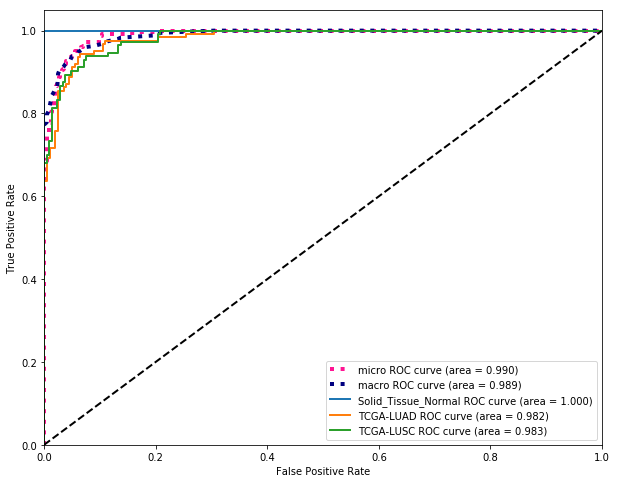

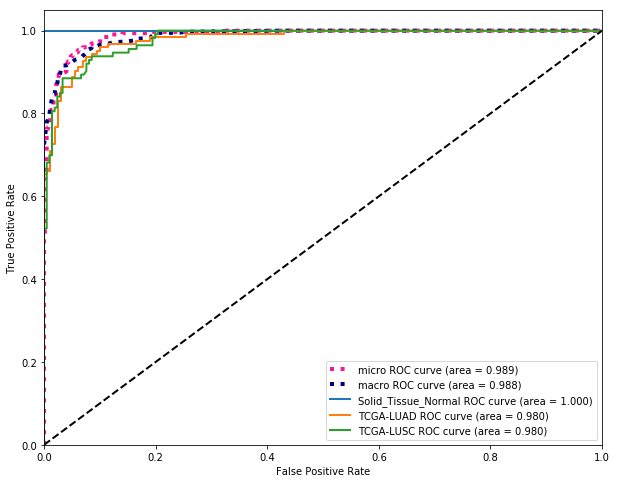

In [32]:
# Draw curves based on average probability
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch)

# Draw curves based on percent of correctly classified tiles
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch)


